# 資料前處理

## 載入必要之函式庫

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## 歷史出入庫資料-益張

### 資料前處理

In [2]:
# 讀資料
item = 'A'  # 選擇要載入的'品項'
Location = pd.ExcelFile('./data/歷史出入庫資料-益張.xlsx')
df = pd.read_excel(Location, item)
df

,品項,異動日期,入/出庫,異動數量
0,A,2020/03/19,入庫,647
1,A,2020/03/24,入庫,193
2,A,2020/03/24,入庫,330
3,A,2020/03/26,出庫,330
4,A,2020/03/27,出庫,840
...,...,...,...,...
350,A,2022/02/15,出庫,546
351,A,2022/02/17,入庫,865
352,A,2022/02/17,入庫,600
353,A,2022/02/17,入庫,225


In [3]:
# 將日期轉成年分
df['異動日期'] = pd.to_datetime(df['異動日期'])  # 先將日期轉成Datetime格式
df['Year'] = df['異動日期'].dt.year  # 加入年份

# 將日期轉換成週數
df['week'] = df['異動日期'].dt.isocalendar().week #加入週數
#df['week'] = pd.DatetimeIndex(df['異動日期']).week  # 另一種寫法
df

,品項,異動日期,入/出庫,異動數量,Year,week
0,A,2020-03-19,入庫,647,2020,12
1,A,2020-03-24,入庫,193,2020,13
2,A,2020-03-24,入庫,330,2020,13
3,A,2020-03-26,出庫,330,2020,13
4,A,2020-03-27,出庫,840,2020,13
...,...,...,...,...,...,...
350,A,2022-02-15,出庫,546,2022,7
351,A,2022-02-17,入庫,865,2022,7
352,A,2022-02-17,入庫,600,2022,7
353,A,2022-02-17,入庫,225,2022,7


In [4]:
# 將入/出庫拆開
put_in = df
check_out = df
for i in range(df.shape[0]):
    if df['入/出庫'].values[i] == '出庫':
        put_in = put_in.drop(index=[i])  # 刪除出庫，只剩入庫
    elif df['入/出庫'].values[i] == '入庫':
        check_out = check_out.drop(index=[i])
    else:
        print("Error")

print("入庫筆數:", len(put_in))
print("出庫筆數:", len(check_out))
put_in

入庫筆數: 213
出庫筆數: 142


,品項,異動日期,入/出庫,異動數量,Year,week
0,A,2020-03-19,入庫,647,2020,12
1,A,2020-03-24,入庫,193,2020,13
2,A,2020-03-24,入庫,330,2020,13
5,A,2020-04-01,入庫,195,2020,14
6,A,2020-04-03,入庫,198,2020,14
...,...,...,...,...,...,...
347,A,2022-02-11,入庫,750,2022,6
348,A,2022-02-11,入庫,135,2022,6
351,A,2022-02-17,入庫,865,2022,7
352,A,2022-02-17,入庫,600,2022,7


In [5]:
# 相同"異動日期"做加總 + 移動到index
sum_put_in = put_in.groupby(['異動日期'], as_index=False)['異動數量'].sum()  # sum quantitys
sum_put_in['異動日期'] = pd.to_datetime(sum_put_in['異動日期'])  # convert to datetime
sum_put_in = sum_put_in.set_index("異動日期")  # to index
sum_put_in

,異動數量
異動日期,
2020-03-19,647
2020-03-24,523
2020-04-01,195
2020-04-03,198
2020-04-06,322
...,...
2022-01-13,2457
2022-02-08,593
2022-02-10,1270


In [6]:
# 補齊"異動日期"之日數
sum_put_in = sum_put_in.resample("D").mean().fillna(0)  # 空值填0
sum_put_in = sum_put_in.reset_index()
sum_put_in['Year'] = sum_put_in['異動日期'].dt.isocalendar().year  #需加isocalendar()才不會算錯 
sum_put_in['week'] = sum_put_in['異動日期'].dt.isocalendar().week
sum_put_in

,異動日期,異動數量,Year,week
0,2020-03-19,647.0,2020,12
1,2020-03-20,0.0,2020,12
2,2020-03-21,0.0,2020,12
3,2020-03-22,0.0,2020,12
4,2020-03-23,0.0,2020,13
...,...,...,...,...
696,2022-02-13,0.0,2022,6
697,2022-02-14,0.0,2022,7
698,2022-02-15,0.0,2022,7
699,2022-02-16,0.0,2022,7


In [7]:
# columns -> index
sum_put_in = sum_put_in.groupby(['Year','week']).aggregate(sum)
sum_put_in

異動數量
Year week        
2020 12     647.0
     13     523.0
     14     393.0
     15     812.0
     16    1000.0
...           ...
2022 3        0.0
     4        0.0
     5        0.0
     6     2748.0
     7     1690.0

[101 rows x 1 columns]

In [8]:
# check_out做一樣的事
sum_check_out = check_out.groupby(['異動日期'], as_index=False)['異動數量'].sum()  # sum quantitys
sum_check_out['異動日期'] = pd.to_datetime(sum_check_out['異動日期'])  # convert to datetime
sum_check_out = sum_check_out.set_index("異動日期")  # to index
sum_check_out = sum_check_out.resample("D").mean().fillna(0)  # 空值填0
sum_check_out = sum_check_out.reset_index()
sum_check_out['Year'] = sum_check_out['異動日期'].dt.isocalendar().year
sum_check_out['week'] = sum_check_out['異動日期'].dt.isocalendar().week
sum_check_out = sum_check_out.groupby(['Year','week']).aggregate(sum)
sum_check_out

異動數量
Year week        
2020 13    1170.0
     14       0.0
     15    1205.0
     16     955.0
     17     610.0
...           ...
2022 4     1000.0
     5        0.0
     6     1441.0
     7     1146.0
     8      985.0

[101 rows x 1 columns]

### 出入庫-統一日期範圍

In [9]:
# 合併DataFrame (取聯集=outer, 交集=inner)
sum_merge = pd.merge(sum_put_in, sum_check_out, on=['Year','week'], how='outer', suffixes=('_put_in', '_check_out'))
sum_merge = sum_merge.fillna(0)
sum_merge

異動數量_put_in  異動數量_check_out
Year   week                             
2020.0 12.0        647.0             0.0
       13.0        523.0          1170.0
       14.0        393.0             0.0
       15.0        812.0          1205.0
       16.0       1000.0           955.0
...                  ...             ...
2022.0 4.0           0.0          1000.0
       5.0           0.0             0.0
       6.0        2748.0          1441.0
       7.0        1690.0          1146.0
       8.0           0.0           985.0

[102 rows x 2 columns]

In [10]:
# 抓出其中入庫量
sum_put_in = sum_merge
sum_put_in = sum_put_in.drop(columns='異動數量_check_out')
sum_put_in = sum_put_in.rename(columns={'異動數量_put_in':'異動數量'}) 
sum_put_in

異動數量
Year   week        
2020.0 12.0   647.0
       13.0   523.0
       14.0   393.0
       15.0   812.0
       16.0  1000.0
...             ...
2022.0 4.0      0.0
       5.0      0.0
       6.0   2748.0
       7.0   1690.0
       8.0      0.0

[102 rows x 1 columns]

In [11]:
# 抓出其中出庫量
sum_check_out = sum_merge
sum_check_out = sum_check_out.drop(columns='異動數量_put_in')
sum_check_out = sum_check_out.rename(columns={'異動數量_check_out':'異動數量'}) 
sum_check_out

異動數量
Year   week        
2020.0 12.0     0.0
       13.0  1170.0
       14.0     0.0
       15.0  1205.0
       16.0   955.0
...             ...
2022.0 4.0   1000.0
       5.0      0.0
       6.0   1441.0
       7.0   1146.0
       8.0    985.0

[102 rows x 1 columns]

In [12]:
# 庫存相差量 = 入庫量 - 出庫量
inventory = sum_put_in.sub(sum_check_out, fill_value=0)  # fill_value: 自動補齊缺失計算
inventory['相差量'] = inventory['異動數量']
inventory

異動數量     相差量
Year   week                
2020.0 12.0   647.0   647.0
       13.0  -647.0  -647.0
       14.0   393.0   393.0
       15.0  -393.0  -393.0
       16.0    45.0    45.0
...             ...     ...
2022.0 4.0  -1000.0 -1000.0
       5.0      0.0     0.0
       6.0   1307.0  1307.0
       7.0    544.0   544.0
       8.0   -985.0  -985.0

[102 rows x 2 columns]

In [13]:
# 庫存累計量 = 做累加計算
inventory['異動數量'] = inventory['相差量'].cumsum()
#inventory = inventory.rename(columns={'異動數量':'庫存量'})  # 修改columns名稱
inventory

異動數量     相差量
Year   week                
2020.0 12.0   647.0   647.0
       13.0     0.0  -647.0
       14.0   393.0   393.0
       15.0     0.0  -393.0
       16.0    45.0    45.0
...             ...     ...
2022.0 4.0   1376.0 -1000.0
       5.0   1376.0     0.0
       6.0   2683.0  1307.0
       7.0   3227.0   544.0
       8.0   2242.0  -985.0

[102 rows x 2 columns]

In [14]:
# 只保留在庫量
inventory = inventory.drop(columns=['相差量'])
inventory

異動數量
Year   week        
2020.0 12.0   647.0
       13.0     0.0
       14.0   393.0
       15.0     0.0
       16.0    45.0
...             ...
2022.0 4.0   1376.0
       5.0   1376.0
       6.0   2683.0
       7.0   3227.0
       8.0   2242.0

[102 rows x 1 columns]

### 匯出Excel結果

In [15]:
sum_put_in.to_excel('./data/sum_put_in.xlsx', sheet_name=item, index=True)
sum_check_out.to_excel('./data/sum_check_out.xlsx', sheet_name=item, index=True)
inventory.to_excel('./data/inventory.xlsx', sheet_name=item, index=True)

### 可視化結果

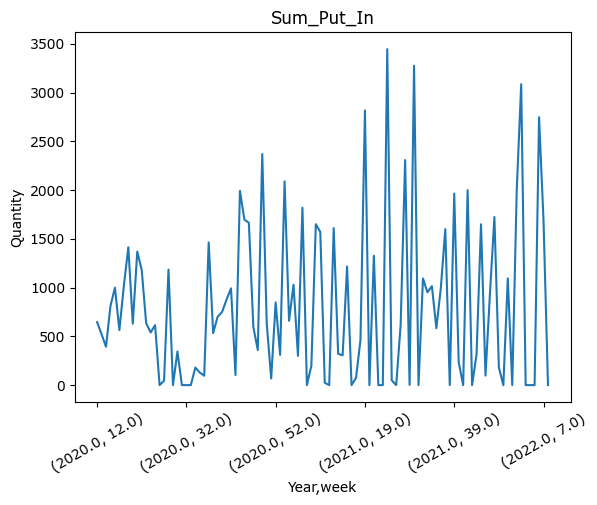

In [16]:
sum_put_in.plot(legend=None, title='Sum_Put_In')  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");

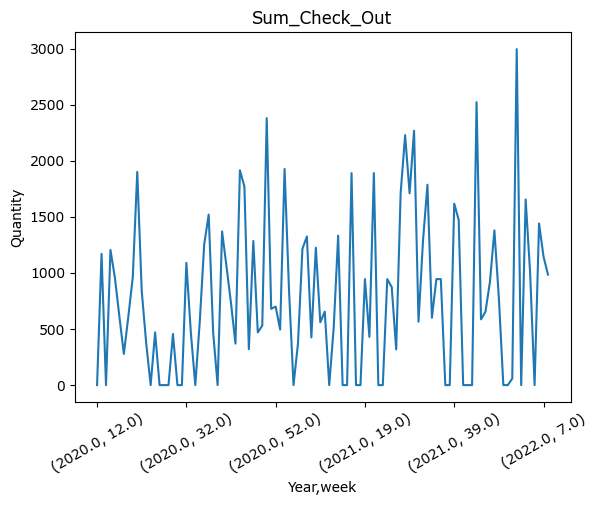

In [17]:
sum_check_out.plot(legend=None, title='Sum_Check_Out')  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");

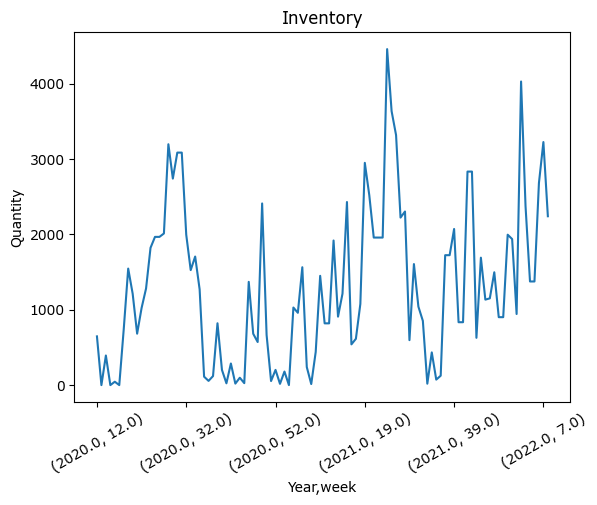

In [18]:
inventory.plot(legend=None, title='Inventory')  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");

## 客戶下單量與庫存量統計表-益張

### 資料前處理

In [19]:
# 讀取原始資料
Location = pd.ExcelFile('./data/客戶下單量與庫存量統計表-益張.xlsx')
df = pd.read_excel(Location, '庫存量狀況')
df = df.fillna(0)
df

,品項,入/出/在,年分,2020年,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157
0,0,0,日期,2020-01-02 00:00:00,2020-01-09 00:00:00,2020-01-16 00:00:00,2020-01-23 00:00:00,2020-01-30 00:00:00,2020-02-06 00:00:00,2020-02-13 00:00:00,...,2021-11-30 00:00:00,2021-12-02 00:00:00,2021-12-07 00:00:00,2021-12-09 00:00:00,2021-12-14 00:00:00,2021-12-16 00:00:00,2021-12-21 00:00:00,2021-12-23 00:00:00,2021-12-28 00:00:00,2021-12-30 00:00:00
1,A,入庫量,0,0,0,0,0,0,0,0,...,0,500,0,1000,0,1500,0,900,0,900
2,0,出庫量,0,0,0,0,0,0,0,0,...,1379,0,0,440,0,0,0,600,58,0
3,0,在庫量,0,0,0,0,0,0,0,0,...,3422,3922,3922,4482,4482,5982,5982,6282,6224,7124
4,B,入庫量,0,0,0,0,0,0,0,0,...,0,500,0,500,0,1000,0,700,0,700
5,0,出庫量,0,0,0,0,0,0,0,0,...,600,0,0,1294,0,0,44,0,360,0
6,0,在庫量,0,0,0,0,0,0,0,0,...,3686,4186,4186,3392,3392,4392,4348,5048,4688,5388
7,C,入庫量,0,0,0,0,0,0,0,0,...,0,2000,0,1000,0,3000,0,1500,0,500
8,0,出庫量,0,0,0,0,0,0,0,0,...,1279,0,0,1142,0,878,1142,2586,0,552
9,0,在庫量,0,0,0,0,0,0,0,0,...,14980,16980,16980,16838,16838,18960,17818,16732,16732,16680


In [20]:
# 在庫量
put_in = pd.DataFrame()
put_in = df.iloc[0:1,15:]
# 出庫量
check_out = pd.DataFrame()
check_out = df.iloc[0:1,15:]
# 在庫量
inventory = pd.DataFrame()
inventory = df.iloc[0:1,15:]

for i in range(1,len(df.index),3):
    put_in = put_in.append(df.iloc[i:i+1,15:])
    check_out = check_out.append(df.iloc[i+1:i+2,15:])
    inventory = inventory.append(df.iloc[i+2:i+3,15:])

put_in = put_in.T
check_out = check_out.T
inventory = inventory.T

put_in

,0,1,4,7,10
Unnamed: 15,2020-03-26,1170,710,1905,1590
Unnamed: 16,2020-04-02,0,0,635,530
Unnamed: 17,2020-04-09,1205,318,2430,1750
Unnamed: 18,2020-04-16,1000,850,2760,1200
Unnamed: 19,2020-04-23,1000,850,2635,2150
...,...,...,...,...,...
Unnamed: 153,2021-12-16,1500,1000,3000,1500
Unnamed: 154,2021-12-21,0,0,0,0
Unnamed: 155,2021-12-23,900,700,1500,1500
Unnamed: 156,2021-12-28,0,0,0,0


In [21]:
# 重新命名、資料格式轉換、年份+週數
column_name = {0:"Date", 1:"A", 4:"B", 7:"C", 10:"D"}
put_in.rename(columns=column_name, inplace=True)
column_name = {0:"Date", 2:"A", 5:"B", 8:"C", 11:"D"}
check_out.rename(columns=column_name, inplace=True)
column_name = {0:"Date", 3:"A", 6:"B", 9:"C", 12:"D"}
inventory.rename(columns=column_name, inplace=True)

put_in['Date'] = pd.to_datetime(put_in['Date'])  # 先將日期轉成Datetime格式
put_in['Year'] = put_in['Date'].dt.year  # 加入年份
put_in['week'] = put_in['Date'].dt.isocalendar().week  #加入週數

check_out['Date'] = pd.to_datetime(check_out['Date'])  # 先將日期轉成Datetime格式
check_out['Year'] = check_out['Date'].dt.year  # 加入年份
check_out['week'] = check_out['Date'].dt.isocalendar().week  #加入週數

inventory['Date'] = pd.to_datetime(inventory['Date'])  # 先將日期轉成Datetime格式
inventory['Year'] = inventory['Date'].dt.year  # 加入年份
inventory['week'] = inventory['Date'].dt.isocalendar().week  # 

put_in

,Date,A,B,C,D,Year,week
Unnamed: 15,2020-03-26,1170,710,1905,1590,2020,13
Unnamed: 16,2020-04-02,0,0,635,530,2020,14
Unnamed: 17,2020-04-09,1205,318,2430,1750,2020,15
Unnamed: 18,2020-04-16,1000,850,2760,1200,2020,16
Unnamed: 19,2020-04-23,1000,850,2635,2150,2020,17
...,...,...,...,...,...,...,...
Unnamed: 153,2021-12-16,1500,1000,3000,1500,2021,50
Unnamed: 154,2021-12-21,0,0,0,0,2021,51
Unnamed: 155,2021-12-23,900,700,1500,1500,2021,51
Unnamed: 156,2021-12-28,0,0,0,0,2021,52


In [22]:
# 在庫量處理
print("原本:\n", inventory.tail())
inventory = inventory.drop_duplicates(subset=['Year','week'], keep='last')  # 丟除童週的重複筆，保留最後(只有在庫量需要)
print("\n後來:\n", inventory.tail())

原本:
                    Date     A     B      C      D  Year  week
Unnamed: 153 2021-12-16  5982  4392  18960  12893  2021    50
Unnamed: 154 2021-12-21  5982  4348  17818  11707  2021    51
Unnamed: 155 2021-12-23  6282  5048  16732  12381  2021    51
Unnamed: 156 2021-12-28  6224  4688  16732  12093  2021    52
Unnamed: 157 2021-12-30  7124  5388  16680  12339  2021    52

後來:
                    Date     A     B      C      D  Year  week
Unnamed: 149 2021-12-02  3922  4186  16980  10497  2021    48
Unnamed: 151 2021-12-09  4482  3392  16838  11393  2021    49
Unnamed: 153 2021-12-16  5982  4392  18960  12893  2021    50
Unnamed: 155 2021-12-23  6282  5048  16732  12381  2021    51
Unnamed: 157 2021-12-30  7124  5388  16680  12339  2021    52


In [23]:
# 在庫量、入庫量、出庫量: "相同年分+週數"之數量做加總
put_in = put_in.groupby(['Year','week']).aggregate(sum)
check_out = check_out.groupby(['Year','week']).aggregate(sum)
inventory = inventory.groupby(['Year','week']).aggregate(sum)

put_in

C:\Users\a123a\anaconda3\envs\Py37\lib\site-packages\pandas\core\apply.py:169: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.
  return getattr(obj, f)()


A     B     C     D
Year week                        
2020 13    1170   710  1905  1590
     14       0     0   635   530
     15    1205   318  2430  1750
     16    1000   850  2760  1200
     17    1000   850  2635  2150
...         ...   ...   ...   ...
2021 48     500   500  2000  1000
     49    1000   500  1000  3000
     50    1500  1000  3000  1500
     51     900   700  1500  1500
     52     900   700   500  1000

[93 rows x 4 columns]

### 匯出Excel結果

In [24]:
# 匯出資料
put_in.to_excel('./data/sum_put_in.xlsx', sheet_name='入庫量', index=True)
check_out.to_excel('./data/sum_check_out.xlsx', sheet_name='出庫量', index=True)
inventory.to_excel('./data/inventory.xlsx', sheet_name='庫存量', index=True)

### 可視化結果

In [25]:
# 選擇想查看之品項
item = 'A'

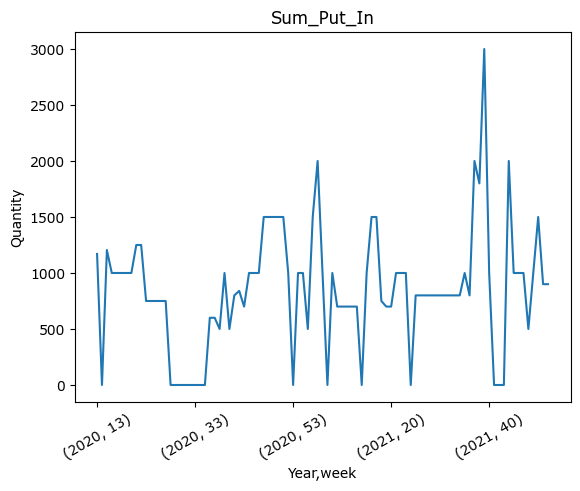

In [26]:
put_in[item].plot(legend=None, title='Sum_Put_In')  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");

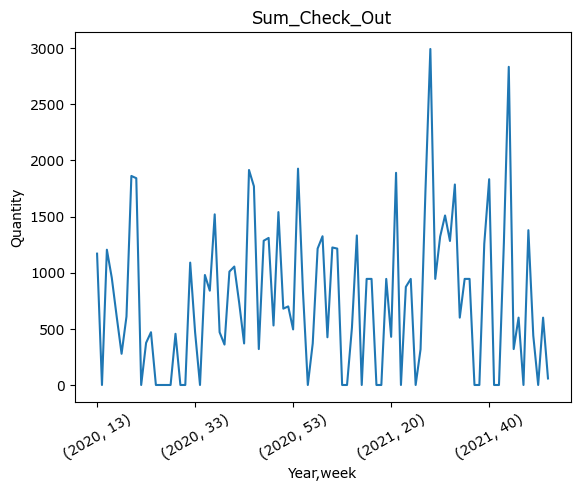

In [27]:
check_out[item].plot(legend=None, title='Sum_Check_Out')  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");

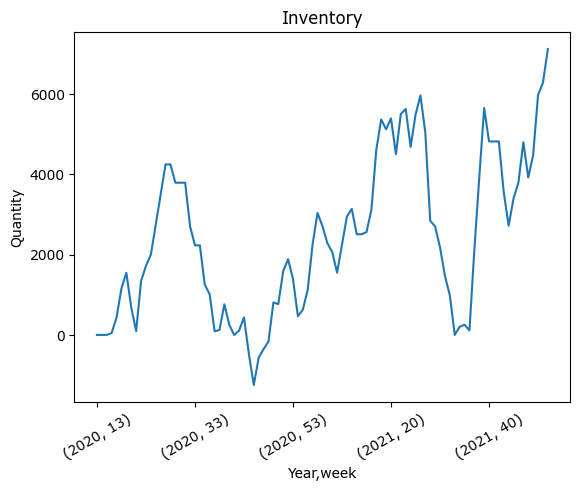

In [28]:
inventory[item].plot(legend=None, title='Inventory')  # None:無標籤
plt.xticks(rotation=30);  # Date轉向30度
plt.ylabel("Quantity");